In [1]:
import sys
path = '/gpfs/commons/groups/gursoy_lab/mstoll/'
sys.path.append(path)

import os
import numpy as np
import pandas as pd
import time
import torch
import pickle
import shap
import tensorboard


from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
from functools import partial
import shutil
from tqdm.auto import tqdm

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

from codes.models.data_form.DataForm import DataTransfo_1SNP
from codes.models.metrics import calculate_roc_auc

import featurewiz as gwiz
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from codes.models.Decision_tree.utils import get_indice, get_name



2024-02-19 09:40:24.469437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 09:40:24.469575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 09:40:24.629588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 09:40:24.699608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 09:40:40.244876: W tensorflow/compiler/tf2

Imported lazytransform v1.13. 

Imported featurewiz 0.5.4. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=0. imbalanced=False,
        		ae_options={})
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


In [2]:
### framework constants:
model_type = 'decision_tree'
model_version = 'gradient_boosting'
test_name = '1_test_train_transfo_V1'
pheno_method = 'Abby' # Paul, Abby
tryout = True # True if we are ding a tryout, False otherwise 
### data constants:
### data constants:
CHR = 1
SNP = 'rs673604'
pheno_method = 'Paul' # Paul, Abby
ld = 'no'
rollup_depth = 4
binary_classes = True #nb of classes related to an SNP (here 0 or 1)
vocab_size = None # to be defined with data
padding_token = 0
prop_train_test = 0.8
load_data = False
save_data = True
remove_none = True
decorelate = False
equalize_label = False
threshold_corr = 0.9
threshold_rare = 50
remove_rare = 'all' # None, 'all', 'one_class'
compute_features = True
padding = False
list_env_features = []
list_pheno_ids = None #list(np.load(f'/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/phewas/list_associations_snps/{SNP}_paul.npy'))

### data format

batch_size = 20
data_share = 1

##### model constants


##### training constants
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
dataT = DataTransfo_1SNP(SNP=SNP,
                         CHR=CHR,
                         method=pheno_method,
                         padding=padding,  
                         pad_token=padding_token, 
                         load_data=load_data, 
                         save_data=save_data, 
                         compute_features=compute_features,
                         prop_train_test=prop_train_test,
                         remove_none=remove_none,
                         equalize_label=equalize_label,
                         rollup_depth=rollup_depth,
                         decorelate=decorelate,
                         threshold_corr=threshold_corr,
                         threshold_rare=threshold_rare,
                         remove_rare=remove_rare, 
                         list_env_features=list_env_features,
                         data_share=data_share,
                         list_pheno_ids=list_pheno_ids,
                         binary_classes=binary_classes, 
                         ld = ld)
#patient_list = dataT.get_patientlist()

In [4]:
data, labels_patients, indices_env, name_envs, eids = dataT.get_tree_data(with_env=False, load_possible=True, only_relevant=False)

In [5]:
equalized = True
interest = False
keep = True
scaled = True
remove = False

In [6]:
frequencies_ini = np.sum(data, axis=0)
print(f'imbalance : {np.sum(labels_patients==0)/len(labels_patients)}')

imbalance : 0.01576089157244476


In [7]:
indices_keep = np.where(frequencies_ini > 2000)[0]
#indices_keep = indices_shaps[:100]
print(f'nb phenos kept : {indices_keep.shape[0]}')


nb phenos kept : 531


In [8]:
names = get_name(dataT, indices_keep)

In [9]:
if keep:
    data_keep = data[:, indices_keep]
    data_use, labels_use= data_keep[np.any(data_keep==1, axis=1)], labels_patients[np.any(data_keep==1, axis=1)]
else:
    data_use, labels_use = data, labels_patients

if interest:
    data_use, labels_use = data[:nb_patients_interest, :-1], labels_patients[:nb_patients_interest]
else:
    data_use, labels_use = data_use, labels_use
if remove:
    eids_remove = np.load('/gpfs/commons/groups/gursoy_lab/mstoll/codes/Data_Files/UKBB/eids_remove_1.npy')
    indices_eids = (1-np.isin(eids, eids_remove)).astype(bool)
    eids_use = eids[indices_eids]
    data_use = data_use[indices_eids]
    labels_use = labels_use[indices_eids]
    
if equalized:
    pheno, labels = DataTransfo_1SNP.equalize_label(data = data_use, labels = labels_use)
else:
    pheno, labels = data_use, labels_use


In [10]:
diseases_patients_train, diseases_patients_test, label_patients_train, label_patients_test = train_test_split(pheno, labels, test_size = 1-prop_train_test, random_state=42)


In [11]:
class_weight = {0: np.sum(label_patients_train == 1) / np.sum(label_patients_train == 0), 1: 1.0}


In [12]:
    
diseases_patients_train_model_unscaled = diseases_patients_train
diseases_patients_test_model_unscaled = diseases_patients_test

if scaled:

    scaler = StandardScaler()
    diseases_patients_train_model= scaler.fit_transform(diseases_patients_train)
    diseases_patients_test_model = scaler.fit_transform(diseases_patients_test)



In [13]:
model = LinearRegression()


# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(diseases_patients_train_model, label_patients_train)

# Faire des prédictions sur l'ensemble de test
labels_pred_test = (model.predict(diseases_patients_test_model) > 0.5).astype(int)
labels_pred_train = (model.predict(diseases_patients_train_model) > 0.5).astype(int)
proba_test = model.predict(diseases_patients_test_model)
proba_train = model.predict(diseases_patients_train_model)

In [14]:
nb_positive_train = np.sum(labels_pred_train==0)
nb_negative_train = np.sum(labels_pred_train==1)
nb_positive_test = np.sum(labels_pred_test==0)
nb_negative_test = np.sum(labels_pred_test==1)

TP_test = np.sum((label_patients_test==0 )& (labels_pred_test == 0)) / nb_positive_test
FP_test = np.sum((label_patients_test==1 )& (labels_pred_test == 0)) / nb_positive_test
TN_test = np.sum((label_patients_test==1 )& (labels_pred_test == 1)) / nb_negative_test
FN_test = np.sum((label_patients_test== 0)& (labels_pred_test == 1)) / nb_negative_test

TP_train = np.sum((label_patients_train==0 )& (labels_pred_train == 0)) / nb_positive_train
FP_train = np.sum((label_patients_train==1 )& (labels_pred_train == 0)) / nb_positive_train
TN_train = np.sum((label_patients_train==1 )& (labels_pred_train == 1)) / nb_negative_train
FN_train = np.sum((label_patients_train== 0)& (labels_pred_train == 1)) / nb_negative_train

accuracy_train = accuracy_score(label_patients_train, labels_pred_train)
accuracy_test = accuracy_score(label_patients_test, labels_pred_test)

auc_test = calculate_roc_auc(label_patients_test, proba_test)
auc_train = calculate_roc_auc(label_patients_train, proba_train)

proba_avg_zero_test = 1- np.mean(proba_test[label_patients_test==0])
proba_avg_zero_train = 1- np.mean(proba_train[label_patients_train==0])
proba_avg_one_test = np.mean(proba_test[label_patients_test==1])
proba_avg_one_train = np.mean(proba_train[label_patients_train==1])

num classes = 2
num classes = 2


In [15]:
print(f'{TP_test=}') 
print(f'{FP_test=}')
print(f'{TN_test=}')
print(f'{FN_test=}')
print(f'{TP_train=}') 
print(f'{FP_train=}')
print(f'{TN_train=}')
print(f'{FN_train=}')
print(' ')
print(f'{auc_test=}')
print(f'{auc_train=}')
print(' ')
print(' ')
print(f'{accuracy_test=}')
print(f'{accuracy_train=}')
print(' ')
print(f'{proba_avg_zero_test=}')
print(f'{proba_avg_zero_train=}')
print(f'{proba_avg_one_test=}')
print(f'{proba_avg_one_train=}')

TP_test=0.5039912917271407
FP_test=0.4960087082728592
TN_test=0.0
FN_test=1.0
TP_train=0.6257813819902011
FP_train=0.37421861800979894
TN_train=0.6480720297514191
FN_train=0.3519279702485809
 
auc_test=0.6186002397058737
auc_train=0.6968945126129898
 
 
accuracy_test=0.5036258158085569
accuracy_train=0.636108088501995
 
proba_avg_zero_test=-3128044045.832825
proba_avg_zero_train=0.5569363974404969
proba_avg_one_test=-3182962156.3734183
proba_avg_one_train=0.5588672874921246


In [16]:
coeffs = model.coef_

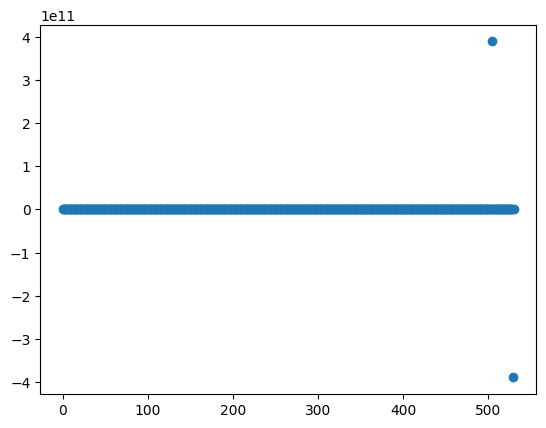

In [17]:
plt.plot(coeffs, 'o')

In [18]:
coeffs

array([ 1.11088083e-02, -5.09718026e-03,  1.31741363e-02,  2.85381102e-03,
       -2.10328698e-02, -9.93227654e-04,  1.24481299e-03,  2.56489794e-03,
        5.42923631e-03, -3.38871466e-03,  1.01632222e-02,  5.77257065e-03,
        1.33028360e-03, -7.44099020e-03, -2.13376714e-03, -1.34399202e-02,
       -2.69568774e-03, -1.76562040e-02,  1.14699971e-02,  4.52392180e-03,
        6.14833385e-03,  1.56769008e-03, -1.88029627e-02,  3.86067456e-03,
       -3.84375918e-03,  5.30628621e-03,  1.61505019e-02,  6.04040038e-03,
       -6.37805889e-03, -9.30738038e-03, -4.18938753e-03,  9.13109631e-03,
        1.52862279e-02,  1.97565485e-03, -2.78164620e-03,  2.17209106e-03,
        1.58706983e-03,  2.39635461e-03,  2.21598346e-04,  7.07470750e-03,
       -3.11608003e-05, -1.28374231e-02,  8.48547214e-03, -4.16402953e-03,
        5.84467061e-03, -5.51655244e-03, -4.83172419e-03,  3.26754318e-03,
        7.13282792e-04, -9.43763428e-03, -1.29593981e-02,  4.97113211e-03,
        2.00045925e-02, -

### Pairwise

In [19]:
indice = get_indice(dataT, 'Actinic keratosis')

In [20]:
x = data[:, indice]


In [21]:
np.corrcoef(x, labels_patients)

array([[1.        , 0.01190219],
       [0.01190219, 1.        ]])

In [26]:
def get_corr_pheno(data, labels, pheno_nb):    
    corr = np.corrcoef(data[:, pheno_nb], labels)[0,1]
    return corr


In [27]:
get_corr_pheno = partial(get_corr_pheno, diseases_patients_train_model_unscaled, label_patients_train)

In [28]:
phenos = np.arange(len(diseases_patients_train_model[0]))
corrs = np.array(list(map(get_corr_pheno, phenos)))


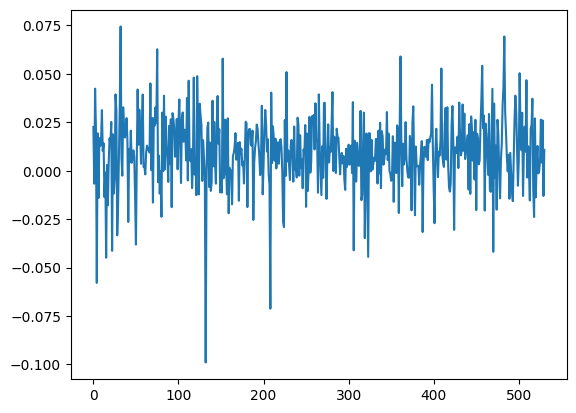

In [29]:
plt.plot(corrs)

In [30]:
indices = np.argsort(np.abs(corrs))[::-1]

In [31]:
get_name(dataT, indices)

['Cerebrovascular accident',
 'Genitourinary tract hemorrhage',
 'Stress-related problem',
 'Malignant melanoma',
 'Esophagitis',
 'Miscarriage',
 'Keratosis pilaris',
 'Cellulitis',
 'Chronic tubotympanic catarrh',
 'Keloid scar',
 'Actinic keratosis',
 'Respiratory failure',
 'Colostomy and enterostomy malfunction',
 'Multiple superficial injuries of abdomen, lower back and pelvis',
 'Superficial injury',
 'Squamous cell carcinoma in situ',
 'Old myocardial infarction',
 'Depressive disorder',
 'Triggering of digit',
 'Abscess of skin and/or subcutaneous tissue',
 'Sequelae of cerebral infarction',
 'Simple goiter',
 'Renal disorder due to type 1 diabetes mellitus',
 'Disorder of eyelid',
 'Septic shock',
 'Hypertensive disorder',
 'Lymphadenopathy',
 'Adverse effect of prosthetic device',
 'Hemiplegia',
 'Allergic reaction to drug',
 'Contact dermatitis',
 'Scoliosis deformity of spine',
 'Brachial (cervical) neuritis',
 'Pulmonary embolism',
 'Hypothyroidism',
 'Spinal stenosis of 

531


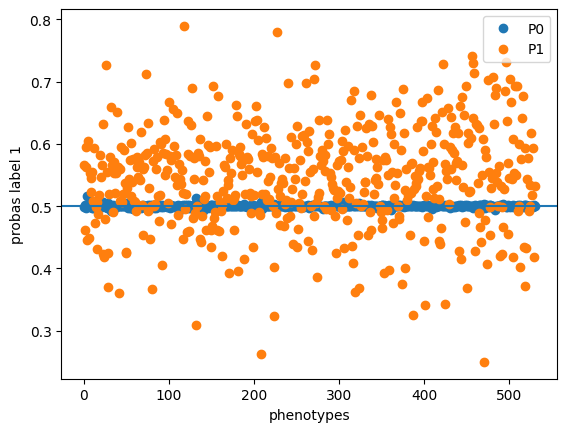

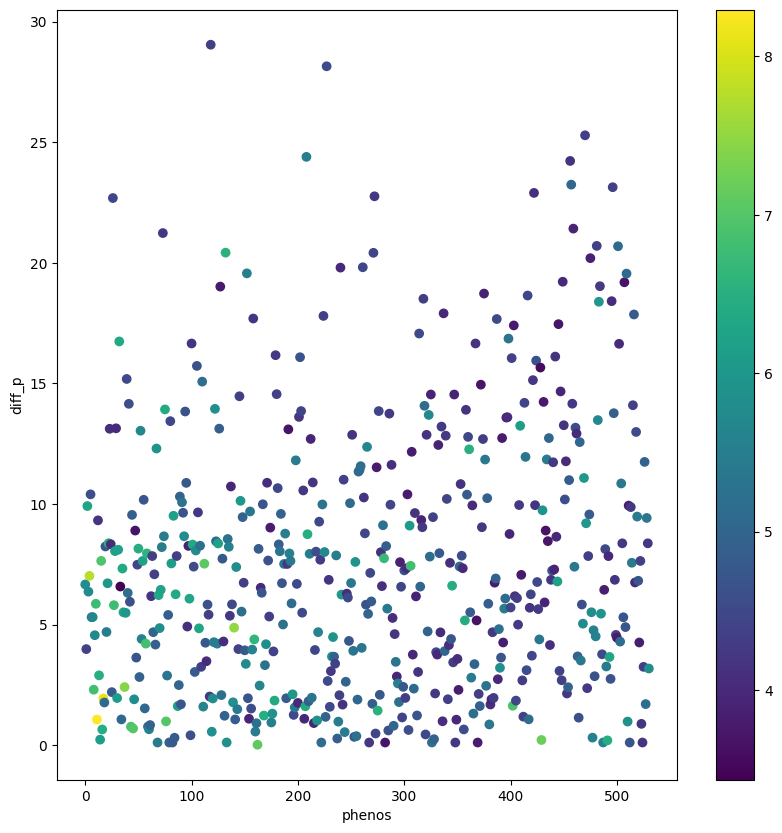

In [32]:
def get_F_pheno(data, labels, pheno_nb):    
    labels_1 = labels[data[:,pheno_nb]==1]
    labels_0 = labels[data[:,pheno_nb]==0]
    P0 = np.sum(labels_0==1)/len(labels_0)
    P1 = np.sum(labels_1==1)/len(labels_1)
    F0 = max(P0, 1-P0)
    F1 = max(P1, 1-P1)
    return P0, P1
def get_plots_F(data, labels):
    
    get_risk_pheno = partial(get_F_pheno, data, labels)
    frequencies = np.sum(data, axis=0) / len(data)
    seuil_frequencies = -1
    indices = frequencies*len(data) > seuil_frequencies
    print(indices.sum())
    proba_mean = max(np.sum(labels==0)/len(labels), 1-np.sum(labels==0)/len(labels))
    phenos = np.arange(len(data[0]))[indices]
    Fs = np.array(list(map(get_risk_pheno, phenos)))

    plt.plot(Fs[:,0], 'o')
    plt.plot(Fs[:, 1], 'o')
    plt.xlabel('phenotypes')
    plt.ylabel('probas label 1')
    plt.axhline(proba_mean)
    log_freq = np.log(frequencies*len(data)+1)[indices]
    color_values = log_freq

    diff_p = np.abs(Fs[:,0]-Fs[:,1]) *100
    plt.legend(['P0', 'P1'])

    fig = plt.subplots(figsize=(10, 10))
    plt.scatter(np.arange(len(diff_p)), diff_p, c=color_values, cmap='viridis')
    plt.xlabel('phenos')
    plt.ylabel('diff_p')
    plt.colorbar()
    return Fs
Fs = get_plots_F(diseases_patients_train_model_unscaled, label_patients_train)



In [33]:
indices_corr = np.argsort(np.abs(corrs))[::-1]
diff_p = np.abs(Fs[:,0]-Fs[:,1]) *100

indices_fs = np.argsort(diff_p)[::-1]

In [41]:
diff_p

0.0

In [34]:
get_name(dataT, indices_corr)

['Cerebrovascular accident',
 'Genitourinary tract hemorrhage',
 'Stress-related problem',
 'Malignant melanoma',
 'Esophagitis',
 'Miscarriage',
 'Keratosis pilaris',
 'Cellulitis',
 'Chronic tubotympanic catarrh',
 'Keloid scar',
 'Actinic keratosis',
 'Respiratory failure',
 'Colostomy and enterostomy malfunction',
 'Multiple superficial injuries of abdomen, lower back and pelvis',
 'Superficial injury',
 'Squamous cell carcinoma in situ',
 'Old myocardial infarction',
 'Depressive disorder',
 'Triggering of digit',
 'Abscess of skin and/or subcutaneous tissue',
 'Sequelae of cerebral infarction',
 'Simple goiter',
 'Renal disorder due to type 1 diabetes mellitus',
 'Disorder of eyelid',
 'Septic shock',
 'Hypertensive disorder',
 'Lymphadenopathy',
 'Adverse effect of prosthetic device',
 'Hemiplegia',
 'Allergic reaction to drug',
 'Contact dermatitis',
 'Scoliosis deformity of spine',
 'Brachial (cervical) neuritis',
 'Pulmonary embolism',
 'Hypothyroidism',
 'Spinal stenosis of 

In [35]:
get_name(dataT, indices_fs)

['Multiple superficial injuries of abdomen, lower back and pelvis',
 'Actinic keratosis',
 'Septic shock',
 'Stress-related problem',
 'Sprain of spinal ligament',
 'Chronic tubotympanic catarrh',
 'Brachial (cervical) neuritis',
 'Mucous polyp of cervix',
 'Disorder of pelvic region of trunk',
 'Contact dermatitis',
 'Herpes zoster',
 'Local infection of wound',
 'Drug-induced hypoglycemia without coma',
 'Respiratory failure',
 'Cerebrovascular accident',
 'Traumatic hemothorax',
 'Sequela of cerebrovascular accident',
 'Knee joint effusion',
 'Onychomycosis',
 'Keratosis pilaris',
 'Superficial injury',
 'Vertebral artery syndrome',
 'Infestation by Sarcoptes scabiei var hominis',
 'Disorder of pericardium',
 'Neck sprain',
 'Ganglion of ankle',
 'Postherpetic neuralgia',
 'Boils of multiple sites',
 'Foreign body granuloma of skin',
 'Malignant melanoma',
 'Temporomandibular joint-pain-dysfunction syndrome',
 'Polyp of nasal sinus',
 'Allergic rhinitis',
 'Glaucoma suspect',
 'Hebe

In [135]:
indices_fs

array([118, 227, 470, 208, 456, 457, 496, 422, 272,  26, 459,  73, 481,
       501, 132, 271, 475, 261, 240, 152, 509, 449, 507, 484, 127, 375,
       416, 318, 495, 483, 337, 516, 224, 158, 387, 445, 403, 314, 398,
        32, 100, 367, 502, 179, 442, 202, 401, 424, 105, 428,  39, 421,
       110, 372, 447, 180, 325, 347, 145, 431, 413, 458,  41, 515, 319,
       122,  75, 358, 276, 203,  94, 497, 286, 323, 201, 397, 396, 482,
        80, 450, 409, 335, 461,  29, 126,  23, 191,  52, 518, 462, 251,
       321, 339, 360, 392, 436, 212, 374, 465, 332, 265,  67, 361, 307,
       414, 434, 376, 198, 452, 526, 440, 288, 259, 274, 258, 257, 469,
       243, 455, 214, 171,  95, 504, 353, 137, 181, 205,   5, 303, 359,
        89, 262, 378, 340, 451,  55, 146,  91, 249, 167, 223, 287, 408,
       423, 364, 511,   2, 513, 430, 155, 106,  92, 310, 184, 474,  44,
        83, 519, 148, 327, 528, 316,  12, 220, 471, 280, 305, 373, 317,
       174,  47, 433, 263, 188, 399, 209,  93,  74, 443, 134, 43

In [136]:
indices_fs

array([118, 227, 470, 208, 456, 457, 496, 422, 272,  26, 459,  73, 481,
       501, 132, 271, 475, 261, 240, 152, 509, 449, 507, 484, 127, 375,
       416, 318, 495, 483, 337, 516, 224, 158, 387, 445, 403, 314, 398,
        32, 100, 367, 502, 179, 442, 202, 401, 424, 105, 428,  39, 421,
       110, 372, 447, 180, 325, 347, 145, 431, 413, 458,  41, 515, 319,
       122,  75, 358, 276, 203,  94, 497, 286, 323, 201, 397, 396, 482,
        80, 450, 409, 335, 461,  29, 126,  23, 191,  52, 518, 462, 251,
       321, 339, 360, 392, 436, 212, 374, 465, 332, 265,  67, 361, 307,
       414, 434, 376, 198, 452, 526, 440, 288, 259, 274, 258, 257, 469,
       243, 455, 214, 171,  95, 504, 353, 137, 181, 205,   5, 303, 359,
        89, 262, 378, 340, 451,  55, 146,  91, 249, 167, 223, 287, 408,
       423, 364, 511,   2, 513, 430, 155, 106,  92, 310, 184, 474,  44,
        83, 519, 148, 327, 528, 316,  12, 220, 471, 280, 305, 373, 317,
       174,  47, 433, 263, 188, 399, 209,  93,  74, 443, 134, 43

In [199]:
N = 1000
X =np.random.binomial(1, 0.9, size=N)
Y =np.random.binomial(1, 0.5, size=N)


In [195]:
P1 = np.sum(Y[X==1]) / np.sum(X==1)
P0 = np.sum(Y[X==0]) / np.sum(X==0)
diff_p = P1 - P0

In [196]:
np.corrcoef(X, Y)[0,1]

0.019268653739269954

In [197]:
diff_p

0.03263274336283184

In [198]:
P0

0.4375

In [95]:
P1, P0

(0.4999137991035107, 0.5000721992491278)

In [214]:
X = diseases_patients_train[:,132]
Y = labels_patients

In [215]:
X.shape

(11028,)

In [216]:
P1 = np.sum(Y[X==1]) / np.sum(X==1)
P0 = np.sum(Y[X==0]) / np.sum(X==0)
diff_p = P1 - P0
corr = np.corrcoef(X, Y)[0,1]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 444518 but corresponding boolean dimension is 11028

In [217]:
diff_p, corr

(-0.0008647901663081381, -0.0006384728175145523)

In [209]:
get_indice(dataT, 'Cerebrovascular accident')

132